In [33]:
import ammonite.ops._

import $ivy.`org.slf4j:slf4j-api:1.7.21`
import $ivy.`org.scalanlp:breeze_2.11:0.12`
import $ivy.`org.scalanlp:breeze-natives_2.11:0.12`

val p = Path("/home") / "kuba" / "Software" / "javaplex-4.2.5.jar"
interp.load.cp(p)

import ammonite.ops._


import $ivy.$                           

import $ivy.$                              

import $ivy.$                                      


p: Path = /home/kuba/Software/javaplex-4.2.5.jar

In [38]:
import scala.collection.JavaConverters._
import edu.stanford.math.plex4._
import edu.stanford.math.plex4.api._
import edu.stanford.math.plex4.visualization._
import edu.stanford.math.plex4.homology.barcodes._

import javax.imageio.ImageIO
import java.io.File

import breeze.linalg._
import breeze.linalg.functions._
import breeze.linalg._
import breeze.math._
import breeze.numerics._
import breeze.util.JavaArrayOps

import scala.collection.JavaConverters._

import edu.stanford.math.plex4._

import edu.stanford.math.plex4.api._

import edu.stanford.math.plex4.visualization._

import edu.stanford.math.plex4.homology.barcodes._


import javax.imageio.ImageIO

import java.io.File


import breeze.linalg._

import breeze.linalg.functions._

import breeze.linalg._

import breeze.math._

import breeze.numerics._

import breeze.util.JavaArrayOps

In [92]:
def barcodeImages(intervals: BarcodeCollection[java.lang.Double]) = {
  val intervalsPerDimension = intervals.getIntervalIterator.asScala.map(x => (x.getKey, x.getValue))toList
  val imgs = intervalsPerDimension map { case (dim, intervals) =>
    (dim, BarcodeVisualizer.drawBarcode(intervals, s"dimension ${dim}", maxFiltrationValue))
  }
  imgs
}

defined function barcodeImages

In [19]:
val stream = Plex4.createExplicitSimplexStream()

stream.addVertex(0)
stream.addVertex(1)
stream.addVertex(2)
stream.addElement(Array(0, 1))
stream.addElement(Array(0, 2))
stream.addElement(Array(1,2))
stream.finalizeStream()

stream.getSize

stream: streams.impl.ExplicitSimplexStream = edu.stanford.math.plex4.streams.impl.ExplicitSimplexStream@123d8a96
res18_8: Int = 6

In [20]:
val persistence = Plex4.getModularSimplicialAlgorithm(3, 2)
val circleIntervals = persistence.computeIndexIntervals(stream)


persistence: homology.interfaces.AbstractPersistenceAlgorithm[homology.chain_basis.Simplex] = edu.stanford.math.plex4.autogen.homology.IntAbsoluteHomology@4b3230f5
circleIntervals: BarcodeCollection[Integer] = Dimension: 0
[0, infinity)
Dimension: 1
[0, infinity)


## 9 - sphere 

In [31]:
val dimension = 9
val stream = Plex4.createExplicitSimplexStream()
stream.addElement(0 to (dimension + 1) toArray)
stream.ensureAllFaces()
stream.removeElementIfPresent(0 to (dimension + 1) toArray)
stream.finalizeStream()

val persistence9 = Plex4.getModularSimplicialAlgorithm(dimension + 1, 2)

dimension: Int = 9
stream: streams.impl.ExplicitSimplexStream = edu.stanford.math.plex4.streams.impl.ExplicitSimplexStream@77a154bc
res30_4: Boolean = true
persistence9: homology.interfaces.AbstractPersistenceAlgorithm[homology.chain_basis.Simplex] = edu.stanford.math.plex4.autogen.homology.IntAbsoluteHomology@211e3ce3

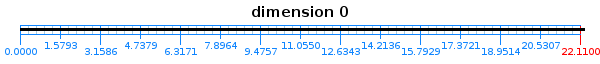

intervals9: BarcodeCollection[java.lang.Double] = Dimension: 0
[0.0, infinity)


In [93]:
val intervals9 = persistence.computeIntervals(stream)

barcodeImages(intervals9) foreach { case (dim, img) => publish.png(img) }

# House

### Explicit stream

In [24]:
val houseStream = Plex4.createExplicitSimplexStream();
houseStream.addVertex(1, 0);
houseStream.addVertex(2, 0);
houseStream.addVertex(3, 0);
houseStream.addVertex(4, 0);
houseStream.addVertex(5, 1);
houseStream.addElement(Array(1, 2), 0);
houseStream.addElement(Array(2,3), 0);
houseStream.addElement(Array(3, 4), 0);
houseStream.addElement(Array(4, 1), 0);
houseStream.addElement(Array(3, 5), 2);
houseStream.addElement(Array(4, 5), 3);
houseStream.addElement(Array(3, 4, 5), 7);
houseStream.finalizeStream()

houseStream: streams.impl.ExplicitSimplexStream = edu.stanford.math.plex4.streams.impl.ExplicitSimplexStream@3da38483

In [25]:
val intervals = persistence.computeIntervals(houseStream)
val actualIntervals = intervals.getIntervalIterator.asScala.map(_.getValue).toList
actualIntervals.length

intervals: BarcodeCollection[java.lang.Double] = Dimension: 0
[1.0, 2.0)
[0.0, infinity)
Dimension: 1
[3.0, 7.0)
[0.0, infinity)

actualIntervals: List[java.util.List[Interval[java.lang.Double]]] = List([[1.0, 2.0), [0.0, infinity)], [[3.0, 7.0), [0.0, infinity)])
res24_2: Int = 2

In [26]:
val intervalsDim0 = BarcodeUtility.getEndpoints(intervals, 1, false) 

intervalsDim0: Array[Array[Double]] = Array(Array(0.0, Infinity), Array(3.0, 7.0))

### Vietoris-Rips from point cloud

In [80]:
val pointCloud = examples.PointCloudExamples.getHouseExample()
val houseMetricSpace= new metric.impl.EuclideanMetricSpace(pointCloud)

val (maxDimension, maxFiltrationValue, numDivisions)= (3, 4.0, 100)

val vietorisRipsStream = api.Plex4.createVietorisRipsStream(
  houseMetricSpace,
  maxDimension,
  maxFiltrationValue,
  numDivisions)

val houseIntervals = persistence.computeIntervals(vietorisRipsStream)

pointCloud: Array[Array[Double]] = Array(
  Array(-1.0, 0.0),
  Array(1.0, 0.0),
  Array(1.0, 2.0),
  Array(-1.0, 2.0),
  Array(0.0, 3.0)
)
houseMetricSpace: metric.impl.EuclideanMetricSpace = edu.stanford.math.plex4.metric.impl.EuclideanMetricSpace@4e53e920
maxDimension: Int = 3
maxFiltrationValue: Double = 4.0
numDivisions: Int = 100
vietorisRipsStream: streams.impl.VietorisRipsStream[Array[Double]] = edu.stanford.math.plex4.streams.impl.VietorisRipsStream@7efc8440
houseIntervals: BarcodeCollection[java.lang.Double] = Dimension: 0
[0.0, 1.4000000000000001)
[0.0, 1.4000000000000001)
[0.0, 2.0)
[0.0, 2.0)
[0.0, infinity)
Dimension: 1
[2.0, 2.8000000000000003)


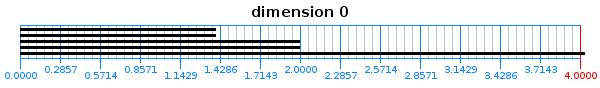

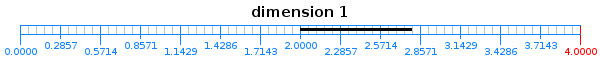

houseImgs: List[(Integer, java.awt.image.BufferedImage)] = List(
  (
    0,
    BufferedImage@42483860: type = 5 ColorModel: #pixelBits = 24 numComponents = 3 color space = java.awt.color.ICC_ColorSpace@46e228e4 transparency = 1 has alpha = false isAlphaPre = false ByteInterleavedRaster: width = 600 height = 88 #numDataElements 3 dataOff[0] = 2
  ),
  (
    1,
    BufferedImage@22962612: type = 5 ColorModel: #pixelBits = 24 numComponents = 3 color space = java.awt.color.ICC_ColorSpace@46e228e4 transparency = 1 has alp...

In [85]:
val houseImgs = barcodeImages(houseIntervals)
houseImgs.foreach { case (dim, img) => publish.png(img) }

## Torus homology 

In [127]:
val torusAllData = csvread(new File("data/pointsTorusGrid.mat"))


: 

## Iris homology 

In [47]:
val irisAllData = csvread(new File("data/iris.csv"))

val irisData = allData(::, Range(1,5))
val irisTarget = allData(::, 4).map(_.toInt)

def dist(X: DenseMatrix[Double], Y: DenseMatrix[Double]): DenseMatrix[Double] = {
  val XdotY = -2.0 * (X * Y.t)
  val XdotX = diag(X * X.t)
  val YdotY = diag(Y * Y.t)
  val tmp1 =  XdotY(::, *) + XdotX
  tmp1(*, ::) + YdotY
}

val irisDist = dist(irisData, irisData)


irisAllData: DenseMatrix[Double] = 5.1  3.5  1.4  0.2  1.0  
4.9  3.0  1.4  0.2  1.0  
4.7  3.2  1.3  0.2  1.0  
4.6  3.1  1.5  0.2  1.0  
5.0  3.6  1.4  0.2  1.0  
5.4  3.9  1.7  0.4  1.0  
4.6  3.4  1.4  0.3  1.0  
5.0  3.4  1.5  0.2  1.0  
4.4  2.9  1.4  0.2  1.0  
4.9  3.1  1.5  0.1  1.0  
5.4  3.7  1.5  0.2  1.0  
4.8  3.4  1.6  0.2  1.0  
...
irisData: DenseMatrix[Double] = 3.5  1.4  0.2  1.0  
3.0  1.4  0.2  1.0  
3.2  1.3  0.2  1.0  
3.1  1.5  0.2  1.0  
3.6  1.4  0.2  1.0  
3.9  1.7  0.4  1.0  
3.4  1.4  0.3  1.0  
3.4  1.5  0.2  1.0  
2.9  1.4  0.2  1.0  
3.1  1.5  0.1  1.0  
3.7  1.5  0.2  1.0  
3.4  1.6  0.2  1.0  
...
irisTarget: DenseVector[Int] = DenseVector(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 

In [123]:
val (maxDimension, maxFiltrationValue, numDivisions) = (3, 10, 10)
val irisStream = Plex4.createVietorisRipsStream(irisMetricSpace, maxDimension, maxFiltrationValue, numDivisions)


maxDimension: Int = 3
maxFiltrationValue: Int = 10
numDivisions: Int = 10
irisStream: streams.impl.VietorisRipsStream[Array[Double]] = edu.stanford.math.plex4.streams.impl.VietorisRipsStream@6fb49c0d

In [124]:
println(Seq(
  "Iris Stream for",
  s"maxFiltrationValue = ${maxFiltrationValue}",
  s"has ${irisStream.asScala.size.toString} simplices").mkString("\n"))

Iris Stream for
maxFiltrationValue = 10
has 13129 simplices


In [125]:
val intervals = persistence.computeIntervals(irisStream)
val imgs = barcodeImages(intervals) 

intervals: BarcodeCollection[java.lang.Double] = Dimension: 0
[0.0, 1.0)
[0.0, 1.0)
[0.0, 1.0)
[0.0, 1.0)
[0.0, 1.0)
[0.0, 1.0)
[0.0, 1.0)
[0.0, 1.0)
[0.0, 1.0)
[0.0, 1.0)
[0.0, 1.0)
...
imgs: List[(Integer, java.awt.image.BufferedImage)] = List(
  (
    0,
    BufferedImage@14caf90: type = 5 ColorModel: #pixelBits = 24 numComponents = 3 color space = java.awt.color.ICC_ColorSpace@46e228e4 transparency = 1 has alpha = false isAlphaPre = false ByteInterleavedRaster: width = 600 height = 916 #numDataElements 3 dataOff[0] = 2
  ),
  (
    1,
    BufferedImage@474f96dd: type = 5 ColorModel: #pixelBits = 24 numComponents = 3 color space = java.awt.color.ICC_ColorSpace@46e228e4 transparency = 1 has alp...

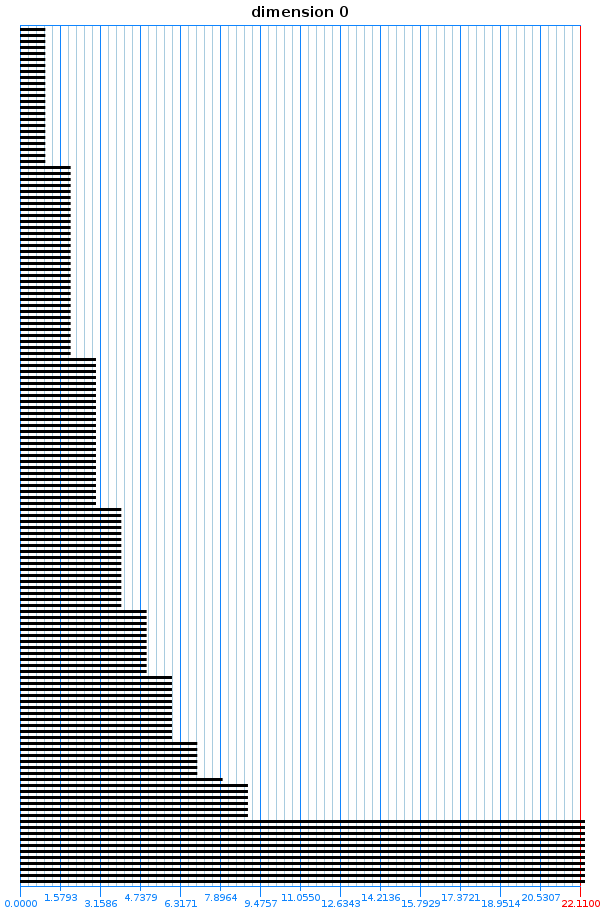

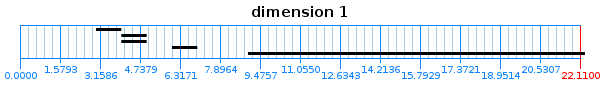

In [126]:
imgs.foreach { case (dim, img) => publish.png(img) }

res111: Double = 6.649812027418519